In [3]:
from datasets import load_dataset
from collections import Counter
import re
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
dataset = load_dataset("imdb")
train_data=dataset["train"]
test_data=dataset["test"]

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
train_data[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

# Build vocab

In [6]:
def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

all_tokens = []
for sample in train_data:
    all_tokens.extend(tokenize(sample["text"]))

token_freq = Counter(all_tokens)

vocab_size = 10000
most_common = token_freq.most_common(vocab_size - 4)

vocab = {
    "<PAD>": 0,
    "<UNK>": 1,
    "<CLS>": 2,
    "<SEP>": 3
}

for idx, (word, _) in enumerate(most_common, start=4):
    vocab[word] = idx

inv_vocab = {v: k for k, v in vocab.items()}

# Tokenization

In [7]:
def encode(text, max_len=128):
    tokens = tokenize(text)
    token_ids = [vocab.get(tok, vocab["<UNK>"]) for tok in tokens]
    token_ids = [vocab["<CLS>"]] + token_ids[:max_len - 2] + [vocab["<SEP>"]]
    
    pad_len = max_len - len(token_ids)
    token_ids += [vocab["<PAD>"]] * pad_len
    return token_ids

In [8]:
class IMDBDataset(Dataset):
    def __init__(self, split):
        self.data = dataset[split]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]["text"]
        label = self.data[idx]["label"]
        token_ids = encode(text)
        return torch.tensor(token_ids), torch.tensor(label)

# Create loaders
train_set = IMDBDataset("train")
test_set = IMDBDataset("test")

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32)

# Encoder

In [9]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None):
        # Multi-head self-attention
        attn_output, _ = self.attention(x, x, x, attn_mask=attn_mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Feed-forward
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x


In [10]:
class SentimentTransformer(nn.Module):
    def __init__(self, vocab_size, max_len, embed_dim, num_heads, ff_dim, num_layers, num_classes):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, max_len, embed_dim))
        
        self.encoder_blocks = nn.Sequential(
            *[TransformerEncoderBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)]
        )
        
        self.pool = nn.AdaptiveAvgPool1d(1)  # Mean pooling over tokens
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len)
        token_emb = self.token_embed(x)                    # (B, L, D)
        x = token_emb + self.pos_embed[:, :x.size(1), :]   # (B, L, D)
        x = self.encoder_blocks(x)                         # (B, L, D)
        
        x = x.permute(0, 2, 1)                             # (B, D, L) for pooling
        x = self.pool(x).squeeze(-1)                       # (B, D)
        return self.classifier(x)                          # (B, num_classes)

# Loss, Optimizer, Device

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embed_dim = 128
num_heads = 4
ff_dim = 256
num_layers = 5
num_classes = 2
max_len = 128

model = SentimentTransformer(
    vocab_size=len(vocab),
    max_len=max_len,
    embed_dim=embed_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_layers=num_layers,
    num_classes=num_classes
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [12]:
from tqdm import tqdm

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
    accuracy = correct / total
    avg_loss = total_loss / len(loader)
    return avg_loss, accuracy

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    accuracy = correct / total
    avg_loss = total_loss / len(loader)
    return avg_loss, accuracy

In [13]:
num_epochs = 4
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, test_loader, criterion)
    
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")



Epoch 1/4


100%|██████████| 782/782 [00:21<00:00, 36.58it/s]


Train Loss: 0.5828, Accuracy: 0.6826
Val   Loss: 0.4918, Accuracy: 0.7575

Epoch 2/4


100%|██████████| 782/782 [00:19<00:00, 40.12it/s]


Train Loss: 0.4474, Accuracy: 0.7892
Val   Loss: 0.4608, Accuracy: 0.7802

Epoch 3/4


100%|██████████| 782/782 [00:19<00:00, 39.68it/s]


Train Loss: 0.3804, Accuracy: 0.8308
Val   Loss: 0.4601, Accuracy: 0.7959

Epoch 4/4


100%|██████████| 782/782 [00:19<00:00, 39.58it/s]


Train Loss: 0.3249, Accuracy: 0.8613
Val   Loss: 0.4641, Accuracy: 0.7926


In [14]:
save_path = "/kaggle/working/best_model.pth"
torch.save(model.state_dict(), "sentiment_transformer.pth")

In [15]:
'''def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_parameters(model):,}")'''

'def count_parameters(model):\n    return sum(p.numel() for p in model.parameters() if p.requires_grad)\n\nprint(f"Trainable parameters: {count_parameters(model):,}")'

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Confusion Matrix:
[[ 8931  3569]
 [ 1615 10885]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.71      0.78     12500
    Positive       0.75      0.87      0.81     12500

    accuracy                           0.79     25000
   macro avg       0.80      0.79      0.79     25000
weighted avg       0.80      0.79      0.79     25000



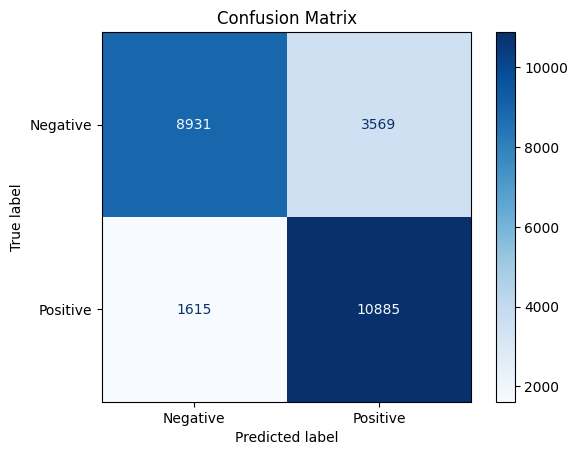

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

report = classification_report(all_labels, all_preds, target_names=["Negative", "Positive"])
print("\nClassification Report:")
print(report)

import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Full Inference

In [18]:
def predict_sentiment(text, model, vocab, max_len=128):
    model.eval() #enable inference mode
    
    tokens = re.findall(r"\b\w+\b", text.lower())
    token_ids = [vocab.get(tok, vocab["<UNK>"]) for tok in tokens]
    token_ids = [vocab["<CLS>"]] + token_ids[:max_len - 2] + [vocab["<SEP>"]]
    pad_len = max_len - len(token_ids)
    token_ids += [vocab["<PAD>"]] * pad_len
    
    input_tensor = torch.tensor([token_ids]).to(device)
    
    with torch.no_grad():
        logits = model(input_tensor)
        prediction = torch.argmax(logits, dim=1).item()
    
    label_map = {0: "Negative", 1: "Positive"}
    return label_map[prediction]

In [19]:
example = "The movie was the bets thing i have ever seen!"
print(predict_sentiment(example, model, vocab))

Positive
